# SCGNN Train - Kaza - PCA

In [2]:
import pandas as pd
import sys
from pathlib import Path
import torch
sys.path.append('../..')
from src import config
from src.utils.dataset import TrafficDataset
from src.utils.model import TrafficPredictor
from torch.utils.data import DataLoader, random_split

In [5]:
DATASET_PATH = config.DATA_INTERIM
jsonl_file = DATASET_PATH / "data.jsonl"
if jsonl_file.exists():
    df = pd.read_json(jsonl_file, lines=True)
    if "traffic_sequence" in df.columns:
        df = pd.DataFrame(df["traffic_sequence"].tolist())
else:
    df = pd.read_parquet(DATASET_PATH / "data.parquet")
df = df.fillna(0)
X_STEP, Y_STEP = 2, 1
data_array = df.values

Epoch 1/50  Train Loss: 226211.2969  Val Loss: 278626.5000  Val MSE: 16199.2151  Val R2: 0.2567
Epoch 2/50  Train Loss: 226201.3594  Val Loss: 278694.9375  Val MSE: 16203.1970  Val R2: 0.2565
Epoch 3/50  Train Loss: 226122.8750  Val Loss: 278767.1875  Val MSE: 16207.3950  Val R2: 0.2563
Epoch 4/50  Train Loss: 226027.2812  Val Loss: 278840.1250  Val MSE: 16211.6331  Val R2: 0.2561
Epoch 5/50  Train Loss: 226030.6094  Val Loss: 278925.2500  Val MSE: 16216.5844  Val R2: 0.2559
Epoch 6/50  Train Loss: 226140.8281  Val Loss: 279009.8125  Val MSE: 16221.5014  Val R2: 0.2556
Epoch 7/50  Train Loss: 225963.6562  Val Loss: 279089.6875  Val MSE: 16226.1446  Val R2: 0.2554
Epoch 8/50  Train Loss: 225842.1406  Val Loss: 279177.4688  Val MSE: 16231.2475  Val R2: 0.2552
Epoch 9/50  Train Loss: 225842.7500  Val Loss: 279270.4062  Val MSE: 16236.6503  Val R2: 0.2549
Epoch 10/50  Train Loss: 225707.1719  Val Loss: 279377.8438  Val MSE: 16242.8967  Val R2: 0.2547
Epoch 11/50  Train Loss: 225663.4688  V

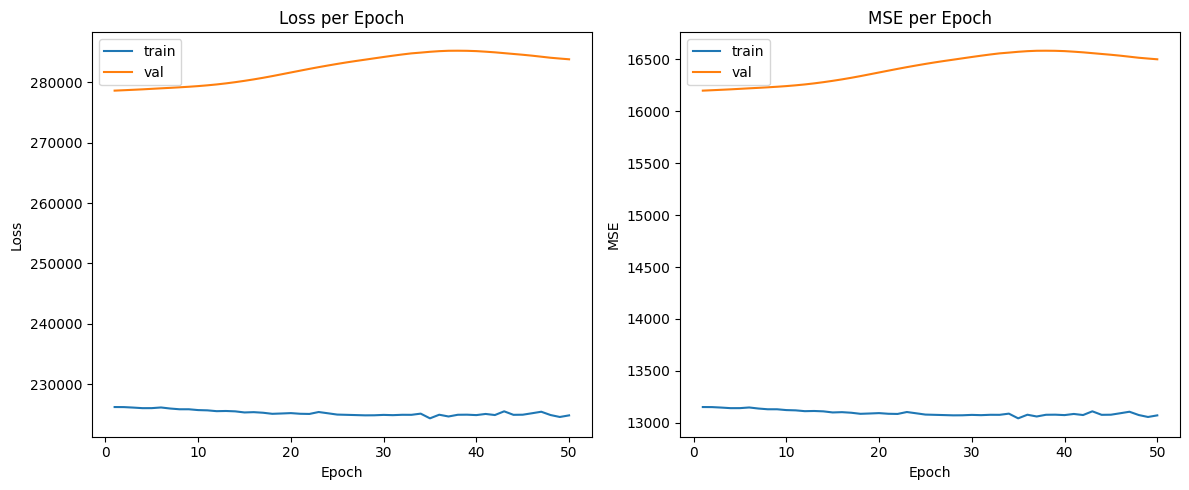

== Final Metrics ==
mse: 16501.103058727305
mae: 81.55353978863049
r2: 0.24281166005490273


In [8]:
PCA_COMPONENTS = 5
dataset = TrafficDataset(data_array, X_STEP, Y_STEP, pca_components=PCA_COMPONENTS)
train_len = int(len(dataset) * 0.8)
val_len = len(dataset) - train_len
train_ds, val_ds = random_split(dataset, [train_len, val_len])
train_loader = DataLoader(train_ds, batch_size=100, shuffle=True, num_workers=8)
val_loader = DataLoader(val_ds, batch_size=100, num_workers=8)
sensors = dataset.sensors
edges = []
for i in range(sensors - 1):
    edges.append([i, i + 1])
    edges.append([i + 1, i])
edge_index = torch.tensor(edges, dtype=torch.long).t()
predictor = TrafficPredictor('scgnn', sensors, X_STEP, Y_STEP, edge_index=edge_index, pca_model=dataset.pca if True else None)
predictor.train(train_loader, val_loader, epochs=50, save_path=config.PROJECT_ROOT.joinpath('models/scgnn_kaza_pca.pt'), save_optimizer=True)
predictor.show()